In [1]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [2]:
# Uninstall
# !pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y

In [3]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [4]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [1]:
# Verify instalation
import torch
import torch_geometric
import torch_scatter

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch_scatter.__version__)
print(torch_geometric.__version__)


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cu124
12.4
True
2.1.2+pt26cu124
2.7.0


In [2]:
from model_PyG import *
from utils import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [4]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [5]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_attr))

### Setup

In [6]:
dataset = "mentos_05" # "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
encoder = "GINE" # Change GIN, GINE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		# "Orange_1", "Orange_2",
		"Red_1", "Red_2",
		# "Yellow_1", "Yellow_2"
	]
	NUM_HIDDEN_LAYERS = 2 # 12
	HIDDEN_DIM = [1024,1024,1024] # [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 16
	lr = 0.0001
	epochs = 100
elif (dataset == "vanessa_05"):
	train_set = [
		"FrescoAmazonas_1", "FrescoAmazonas_2",
		"FrescoCusco_1", "FrescoCusco_2",
		"FrescoSanMartin_1", "FrescoSanMartin_2",
		"SecoAmazonas_1", "SecoAmazonas_2",
		"SecoCusco_1", "SecoCusco_2",
		"SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 150

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)
edge_attr = torch.tensor([
    [0.5, 1.0], 
    [0.5, 1.0], 
    [1.0, 1.5], 
    [1.0, 1.5]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)

print(data)
info(data)

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToUndirected(reduce="mean"),
    T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
    T.ToDevice(device)
])

data = transform(data)
print(data)
info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [7]:
# Only for GIN
""" transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
]) """

# For GIN and GINE
transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToUndirected(reduce="mean"),
    # T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
    T.ToDevice(device)
])

In [ ]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		
		""" if i==1:
			x = x[torch.randperm(x.size(0))] # permutations for test """

		edge_attr = torch.ones((edge_index.size(1), 1)) # Only for test GINE

		data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
		info(data)

		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["vanessa_05", "mentos_05"]: # Change
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, intensity_mean, intensity_std, intensity_cv, presence_ratio, 0, 1, 2, ...

		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup

		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values, dtype=torch.long).t().contiguous()

		edge_attr = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float).view(-1, 1) # [E,1]
		# edge_attr = torch.ones((edge_index.size(0), 1), dtype=torch.float) # Only for test GINE
		""" edge_attr = torch.cat([
			edge_weight.abs(),         # strength
			torch.sign(edge_weight),   # direction (+1, -1)
			edge_weight ** 2           # nonlinearity
		], dim=1) # [E,3] """

		x = torch.tensor(df_nodes.iloc[:, [2, 3, 4]].values, dtype=torch.float) # Change
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		# Reduce number of edges
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float) # [E]
		mask = torch.abs(edge_weight) > 0.9
		edge_index = edge_index[:, mask]
		edge_attr  = edge_attr[mask]

		data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
		data = transform(data)
		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 1777
Num. edges:	 929862
Num. features:	 3
Has isolated:	 False
Has loops:	 False
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 1776, 1776, 1776],
        [   2,    5,    6,  ..., 1770, 1772, 1775]], device='cuda:0')
tensor([[ 1.8872, -2.1626,  5.1084],
        [ 2.0378, -2.1454,  3.2162],
        [ 1.7636, -2.1379,  4.2597],
        ...,
        [ 1.9196,  1.7690,  4.4899],
        [ 2.0216,  1.7732,  4.6991],
        [ 2.3582,  1.7774,  3.5178]], device='cuda:0')
tensor([[-0.9682],
        [-0.9319],
        [ 0.9701],
        ...,
        [-0.9983],
        [ 0.9998],
        [-0.9860]], device='cuda:0')
Validate:	 True
Num. nodes:	 1772
Num. edges:	 975444
Num. features:	 3
Has isolated:	 False
Has loops:	 False
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 1771, 1771, 1771],
        [   5,    6,    8,  ..., 1768, 1769, 1770]], device='cuda:0')
tensor([[ 1.8872, -2.1681,  

In [12]:
train_loader

{'Red_1': Data(x=[1777, 3], edge_index=[2, 929862], edge_attr=[929862, 1]),
 'Red_2': Data(x=[1772, 3], edge_index=[2, 975444], edge_attr=[975444, 1])}

### Train

In [13]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [14]:
def fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-3 # 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]

			# Encoder
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
				# z = F.normalize(z, dim=1)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)

			# Positive edges
			pos_edge_index = data.edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=data.edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			if encoder == "GIN":
				z = model(data.x, data.edge_index).detach()
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr).detach()
			dict_node_embeddings[ts] = z.cpu().numpy()

	torch.cuda.empty_cache()

	return dict_node_embeddings, list_loss

In [15]:
train_set

['Red_1', 'Red_2']

In [16]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

if encoder == "GIN":
	model = TGAE_GIN(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size).to(device)
elif encoder == "GINE":
	model = TGAE_GINE(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(encoder, dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
GINE mentos_05 0.0001 100 3 16 2


Epoch: 27:  26%|██▌       | 26/100 [01:17<03:39,  2.97s/it, Loss: 0.6994]


Stopping early as no improvement has been observed.
Early stopping at epoch 27


### Get embeddings

In [17]:
dict_node_embeddings

{'Red_1': array([[-0.02980478,  0.032259  ,  0.11203232, ..., -0.1171774 ,
          0.06661943,  0.02227696],
        [ 0.02600263,  0.07429226, -0.00571527, ..., -0.19281182,
          0.02960099,  0.0681117 ],
        [-0.00940965,  0.08138078,  0.04546108, ..., -0.1467271 ,
          0.05247504,  0.02339728],
        ...,
        [-0.06142862,  0.07949021, -0.12203718, ...,  0.23018603,
          0.06171317, -0.05937882],
        [-0.06619517,  0.05509813, -0.10062402, ...,  0.23886283,
          0.06253415, -0.05366522],
        [-0.00413564,  0.05996974, -0.1544519 , ...,  0.19369453,
          0.03822852,  0.02985561]], dtype=float32),
 'Red_2': array([[-0.0261192 ,  0.04201059,  0.09910472, ..., -0.12897792,
          0.06135653,  0.02224742],
        [-0.05107963,  0.05521086,  0.1108971 , ..., -0.11313438,
          0.07093043, -0.01974479],
        [-0.00422246,  0.03845039,  0.08294696, ..., -0.14405204,
          0.05060941,  0.054221  ],
        ...,
        [-0.02533583,

### Plot

In [18]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(3549, 16)


array([[-0.02980478,  0.032259  ,  0.11203232, ..., -0.1171774 ,
         0.06661943,  0.02227696],
       [ 0.02600263,  0.07429226, -0.00571527, ..., -0.19281182,
         0.02960099,  0.0681117 ],
       [-0.00940965,  0.08138078,  0.04546108, ..., -0.1467271 ,
         0.05247504,  0.02339728],
       ...,
       [-0.02533583,  0.0368177 , -0.07529163, ...,  0.22723685,
         0.05984335,  0.02256278],
       [-0.07598485,  0.0788874 , -0.0807698 , ...,  0.24501851,
         0.07444368, -0.07460686],
       [-0.06555106,  0.044882  , -0.0592504 , ...,  0.25484958,
         0.07296181, -0.04038351]], dtype=float32)

In [19]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
    labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

3549
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [20]:
list_loss

[5.082265853881836,
 0.8825713396072388,
 0.8559075593948364,
 1.7421455383300781,
 1.3082239627838135,
 0.8084926009178162,
 0.7054116725921631,
 0.707578182220459,
 0.7560640573501587,
 0.8284205198287964,
 0.8525112867355347,
 0.8189210891723633,
 0.7673344016075134,
 0.7284461259841919,
 0.7078994512557983,
 0.6996409893035889,
 0.6972285509109497,
 0.6974892020225525,
 0.6996214389801025,
 0.7030912041664124,
 0.706688404083252,
 0.7090599536895752,
 0.7091000080108643,
 0.7073276042938232,
 0.7046182751655579,
 0.7017530202865601,
 0.6994260549545288]

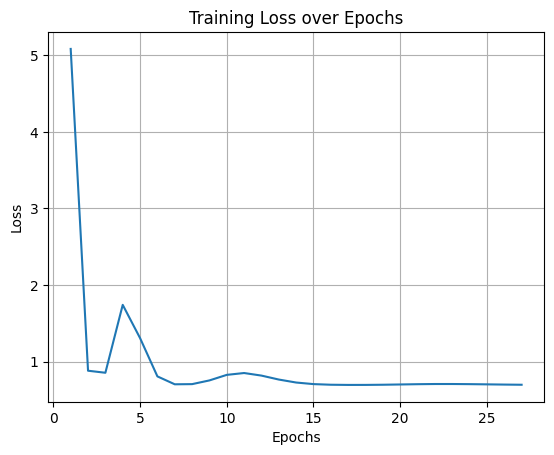

In [21]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
# plt.plot(range(1, len(list_loss) + 1), np.log(list_loss)) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

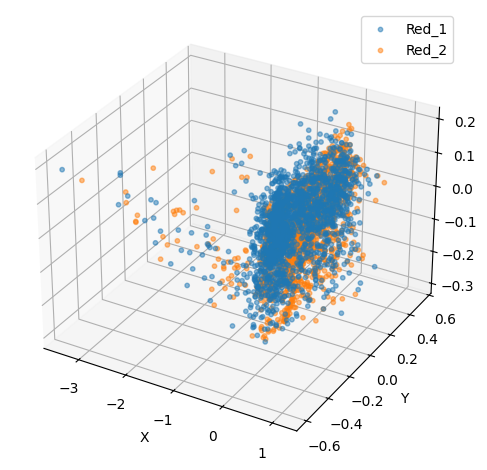

In [22]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

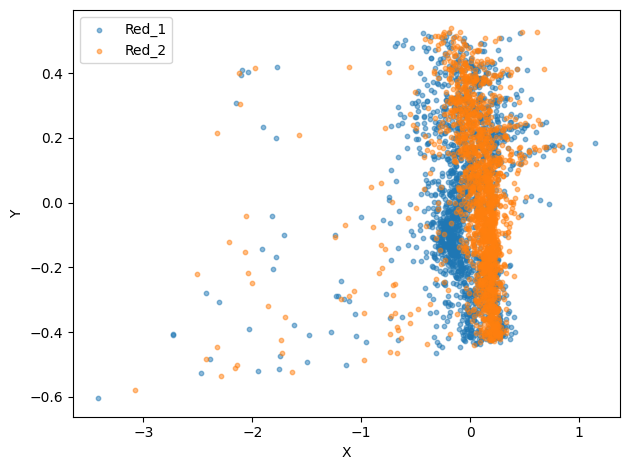

In [23]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()

### Similarity analysis (KNN)

In [24]:
train_set

['Red_1', 'Red_2']

In [25]:
# Get node ids

dict_node_id = {}

if dataset in ["vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
    for ts in train_set:
        dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'Red_1': array([  13,   24,   33, ..., 2301, 2304, 2306]),
 'Red_2': array([  13,   14,   24, ..., 2185, 2225, 2277])}

In [26]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	
	df_node_alignment[ts] = dict_node_id[ts][indices]
df_node_alignment

,Red_1,Red_2
0,13,92
1,24,222
2,33,50
3,40,102
4,50,50
...,...,...
1772,2285,2204
1773,2295,2295
1774,2301,2204
1775,2304,2208


In [27]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

Red_1 Red_2


,Red_1,Red_2
4,50,50
7,70,70
17,128,128
18,132,132
20,140,140
...,...,...
1703,1972,1972
1718,2059,2059
1755,2223,2223
1769,2278,2278


In [28]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
print(len(df_node_alignment_filter))
df_node_alignment_filter

171


,Red_1,Red_2
4,50,50
7,70,70
17,128,128
18,132,132
20,140,140
...,...,...
1703,1972,1972
1718,2059,2059
1755,2223,2223
1769,2278,2278


In [29]:
# Comparison (with test_pairs)

if dataset not in ["vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	# print(test_pairs)
	# print(df_node_alignment.values)
	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	print(df_node_alignment[df_node_alignment["mask"] == True])

### Filter MS data

In [30]:
common_node_id = df_node_alignment_filter.iloc[:, 1].values
common_node_id

array([  50,   70,  128,  132,  140,  181,  192,  261,  279,  314,  333,
        362,  375,  380,  415,  418,  467,  510,  521,  524,  528,  533,
        545,  551,  556,  565,  567,  583,  611,  612,  618,  706,  709,
        743,  747,  762,  766,  791,  807,  808,  822,  823,  851,  857,
        878,  884,  910,  926,  942,  943,  946,  948,  966,  968,  971,
       1003, 1024, 1062, 1067, 1162, 1246, 1247, 1347, 1411, 1462, 1597,
       1649, 1662, 1667, 1668, 1723, 1746, 1759, 1765, 1770, 1772, 1779,
       1812, 1823, 1836, 1843, 1845, 1850, 1852, 1861, 1872, 1883, 1884,
       1890, 1891, 1898, 1907, 1926, 1954, 1991, 1994, 1999, 2001, 2020,
       2021, 2062, 2078, 2094, 2103, 2107, 2118, 2125, 2128, 2164, 2204,
       2212, 2239, 2247, 2257, 2274,  119,  143,  227,  233,  248,  251,
        311,  315,  334,  354,  357,  385,  412,  420,  452,  500,  643,
        691,  700,  705,  711,  742,  751,  786,  820,  825,  846,  872,
        916,  972,  977,  978,  989,  995, 1022, 10

In [31]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/raw.csv".format(dataset), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,...,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3,Blank_1.1,Blank_2.1
4,0.767,353.94570,Unknown,8.253400e-01,9.200000e-06,0.000009,9.200000e-06,9.200000e-06,9.200000e-06,0.000009,...,0.000009,9.200000e-06,0.000009,9.200000e-05,0.000009,6.888500e-01,0.000009,9.200000e-06,14499.11,2.265930e+04
13,0.849,77.12775,Unknown,1.387898e+05,8.624046e+04,72342.450000,1.051718e+05,1.057505e+05,9.259037e+04,117097.500000,...,82741.240000,7.053877e+04,207908.600000,1.581832e+05,120187.200000,9.076510e+04,89014.010000,1.132883e+05,238760.10,9.052885e+04
14,0.862,45.97014,Unknown,6.765457e+04,8.858592e+04,62918.100000,6.450759e+04,9.565974e+04,3.624424e+05,55364.950000,...,171163.700000,4.818176e+05,108095.600000,1.362666e+04,14977.210000,8.767414e+04,124921.300000,1.537605e+04,139203.70,1.000444e+05
24,0.992,109.10390,Unknown,2.234586e+04,2.257770e+04,25630.570000,6.198678e+04,2.216297e+04,3.976091e+04,48250.450000,...,29739.320000,2.090890e+04,10700.320000,4.117690e+03,5520.715000,2.248320e+04,29960.300000,2.081087e+05,106600.00,2.502775e+04
28,1.007,132.12760,Unknown,2.393976e+01,5.186566e+04,3109.359000,6.929501e+03,8.732821e+03,6.296857e+03,21127.380000,...,11475.910000,1.632536e+04,1187.276000,6.521130e+03,3848.260000,2.607996e+04,13962.350000,2.855882e+04,57370.48,3.279362e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,33.631,83.09895,Unknown,2.610749e+05,3.069017e+05,215637.400000,1.398896e+05,1.307836e+05,1.752427e+05,191386.700000,...,299743.400000,2.274897e+05,14049.380000,4.142575e+04,36417.310000,9.815955e+04,161472.700000,2.311965e+05,1397670.00,1.789797e+05
2303,33.653,457.39230,Unknown,1.000000e-07,1.000000e-07,0.000004,1.000000e-07,1.000000e-07,1.000000e-07,0.000001,...,5477.928000,1.000000e-07,17335.640000,1.000000e-07,3668.895000,1.000000e-07,1243.702000,1.000000e-07,51166.44,1.000000e-07
2304,33.666,105.09980,Unknown,4.961273e+04,9.736624e+04,109105.300000,1.165776e+05,1.079196e+05,9.511641e+04,141866.500000,...,139319.000000,1.264424e+05,81152.250000,1.082530e+05,99531.660000,1.189775e+05,198119.500000,1.690732e+05,631228.90,1.729256e+05
2305,33.673,93.09473,Unknown,1.337628e+05,1.239729e+05,91317.910000,9.673636e+04,9.306306e+04,1.107218e+05,122202.900000,...,99013.660000,7.839004e+04,59013.780000,1.218907e+05,142875.100000,2.201098e+05,217304.100000,1.155046e+05,1107215.00,5.177241e+04


In [32]:
print(len(common_node_id), len(df_join_raw))

171 1782


In [33]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
50,1.230,74.28162,Unknown
70,1.438,463.54140,Unknown
128,2.232,56.07196,Unknown
132,2.263,70.06041,Unknown
140,2.493,59.18501,Unknown
...,...,...,...
1972,29.463,91.07032,Unknown
2059,30.656,183.16340,Unknown
2223,32.948,169.82420,Unknown
2278,33.469,441.32800,Unknown


In [34]:
# Comparison (sta vs Van)

list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]

match = set(list_node_id_sta) & set(common_node_id)
print(train_set)
print(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")
print(f"Match comp: {len(match)}/{len(list_node_id_sta)}")
print(match)

['Red_1', 'Red_2']
Alignment: 171 / 1782
Match comp: 1/23
{70}


### Clustering analysis

In [35]:
df_join_raw

,Average Rt,Average Mz,Metabolite name,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,...,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3,Blank_1.1,Blank_2.1
4,0.767,353.94570,Unknown,8.253400e-01,9.200000e-06,0.000009,9.200000e-06,9.200000e-06,9.200000e-06,0.000009,...,0.000009,9.200000e-06,0.000009,9.200000e-05,0.000009,6.888500e-01,0.000009,9.200000e-06,14499.11,2.265930e+04
13,0.849,77.12775,Unknown,1.387898e+05,8.624046e+04,72342.450000,1.051718e+05,1.057505e+05,9.259037e+04,117097.500000,...,82741.240000,7.053877e+04,207908.600000,1.581832e+05,120187.200000,9.076510e+04,89014.010000,1.132883e+05,238760.10,9.052885e+04
14,0.862,45.97014,Unknown,6.765457e+04,8.858592e+04,62918.100000,6.450759e+04,9.565974e+04,3.624424e+05,55364.950000,...,171163.700000,4.818176e+05,108095.600000,1.362666e+04,14977.210000,8.767414e+04,124921.300000,1.537605e+04,139203.70,1.000444e+05
24,0.992,109.10390,Unknown,2.234586e+04,2.257770e+04,25630.570000,6.198678e+04,2.216297e+04,3.976091e+04,48250.450000,...,29739.320000,2.090890e+04,10700.320000,4.117690e+03,5520.715000,2.248320e+04,29960.300000,2.081087e+05,106600.00,2.502775e+04
28,1.007,132.12760,Unknown,2.393976e+01,5.186566e+04,3109.359000,6.929501e+03,8.732821e+03,6.296857e+03,21127.380000,...,11475.910000,1.632536e+04,1187.276000,6.521130e+03,3848.260000,2.607996e+04,13962.350000,2.855882e+04,57370.48,3.279362e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,33.631,83.09895,Unknown,2.610749e+05,3.069017e+05,215637.400000,1.398896e+05,1.307836e+05,1.752427e+05,191386.700000,...,299743.400000,2.274897e+05,14049.380000,4.142575e+04,36417.310000,9.815955e+04,161472.700000,2.311965e+05,1397670.00,1.789797e+05
2303,33.653,457.39230,Unknown,1.000000e-07,1.000000e-07,0.000004,1.000000e-07,1.000000e-07,1.000000e-07,0.000001,...,5477.928000,1.000000e-07,17335.640000,1.000000e-07,3668.895000,1.000000e-07,1243.702000,1.000000e-07,51166.44,1.000000e-07
2304,33.666,105.09980,Unknown,4.961273e+04,9.736624e+04,109105.300000,1.165776e+05,1.079196e+05,9.511641e+04,141866.500000,...,139319.000000,1.264424e+05,81152.250000,1.082530e+05,99531.660000,1.189775e+05,198119.500000,1.690732e+05,631228.90,1.729256e+05
2305,33.673,93.09473,Unknown,1.337628e+05,1.239729e+05,91317.910000,9.673636e+04,9.306306e+04,1.107218e+05,122202.900000,...,99013.660000,7.839004e+04,59013.780000,1.218907e+05,142875.100000,2.201098e+05,217304.100000,1.155046e+05,1107215.00,5.177241e+04


In [36]:
df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:-2] # Important two last column no only to Mentos
df_join_raw_signal

,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,Blank_2.9,Blank_2.10,QC_1.1,...,Red_1.3,Red_2.1,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3
50,1.117319e+05,2.087352e+04,5.358594e+04,5.661241e+04,3.210332e+04,5.446246e+04,70067.900000,9.935264e+04,2.843490e+05,47612.410000,...,2.735881e+04,4.394762e+04,4.510232e+04,3.730376e+04,1.372171e+04,3.569638e+04,1.254843e+04,9.079319e+04,2.192714e+04,8.177053e+04
70,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,0.000004,4.300000e-06,4.300000e-06,0.000004,...,4.300000e-06,4.300000e-06,4.300000e-06,1.762100e-01,1.109668e+04,4.929900e-01,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06
128,9.189675e+04,1.390580e+05,2.185156e+05,2.266498e+05,9.920799e+04,1.127456e+05,167365.500000,9.782882e+04,9.003660e+04,276431.100000,...,1.009428e+06,7.880553e+05,8.004056e+05,1.660360e+05,1.845143e+06,1.766738e+05,4.948432e+05,1.600325e+05,1.749877e+05,3.638997e+05
132,4.346151e+04,9.383098e+04,6.227550e+04,6.575279e+04,4.222636e+04,5.988725e+04,64170.580000,8.629180e+04,3.042639e+05,235417.900000,...,3.265040e+07,1.258051e+07,1.123084e+07,1.282572e+07,1.670467e+05,1.356173e+05,1.679138e+05,1.060207e+05,7.017214e+04,2.241680e+05
140,9.362630e+04,5.649736e+04,6.960310e+04,4.158213e+04,2.187184e+04,1.321207e+06,95950.700000,3.407458e+04,2.721429e+04,631620.400000,...,3.669693e+05,4.340247e+05,1.009497e+06,2.333727e+05,1.029543e+06,3.663880e+05,4.234979e+05,5.226777e+05,7.439218e+05,1.282380e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,5.581693e+05,4.485821e+05,2.384693e+05,2.927203e+05,2.829929e+05,2.763729e+05,341956.100000,2.164273e+05,1.493243e+05,386385.600000,...,3.491773e+05,3.261735e+05,2.347500e+05,4.160862e+05,3.788260e+05,1.011975e+06,1.488836e+06,5.011893e+05,3.994957e+05,3.562081e+05
2059,5.162479e+04,5.684573e+04,3.406825e+04,4.599041e+04,4.534239e+04,3.304717e+04,56068.970000,4.792539e+04,1.752860e+02,66324.150000,...,3.383546e+04,3.997705e+04,4.102050e+04,4.284905e+04,1.772327e+05,3.015683e+05,4.406979e+04,1.887388e+04,3.997655e+04,6.607123e+04
2223,4.721304e+04,2.973065e+04,3.720328e+03,2.063411e+04,2.271357e+04,3.150820e+04,24313.700000,6.807429e+04,1.282224e+04,37088.630000,...,4.733514e+04,4.105754e+04,3.576255e+04,2.435888e+04,6.186642e+04,2.769725e+04,5.666945e+04,2.420154e+04,2.444103e+04,1.688624e+04
2278,4.420000e-15,4.420000e-15,2.340000e-12,4.420000e-15,4.420000e-15,5.328576e+02,0.000003,4.420000e-15,4.420000e-15,0.000050,...,4.420000e-15,4.420000e-15,1.243900e-01,4.420000e-15,1.980000e-05,5.280000e-07,4.420000e-14,4.420000e-15,4.420000e-15,4.420000e-15


In [37]:
df_join_raw_signal_t = df_join_raw_signal.T
df_join_raw_signal_t

,50,70,128,132,140,181,192,261,279,314,...,1694,1721,1792,1793,1819,1972,2059,2223,2278,2295
Blank_2.2,111731.90,0.000004,91896.75,43461.51,93626.30,170388.1,1033048.0,4314.359,3.200000e-05,93388.19,...,348577.7,413528.3,283821.6,44355.36,187035.6,558169.3,51624.790,47213.040,4.420000e-15,103869.10
Blank_2.3,20873.52,0.000004,139058.00,93830.98,56497.36,186487.6,1069329.0,15319.050,1.197027e+01,72559.13,...,225193.2,323904.8,240132.2,52703.73,375846.9,448582.1,56845.730,29730.650,4.420000e-15,139835.80
Blank_2.4,53585.94,0.000004,218515.60,62275.50,69603.10,159979.8,1156904.0,6791.240,1.000000e-07,39277.60,...,148896.4,403820.6,241424.4,75968.30,456880.5,238469.3,34068.250,3720.328,2.340000e-12,117016.30
Blank_2.5,56612.41,0.000004,226649.80,65752.79,41582.13,124485.7,575667.9,10120.390,1.000000e-07,21331.79,...,161659.4,196694.7,205247.3,33004.31,396289.7,292720.3,45990.410,20634.110,4.420000e-15,89746.63
Blank_2.6,32103.32,0.000004,99207.99,42226.36,21871.84,247118.3,414982.3,3227.616,2.426342e+04,56320.27,...,152182.3,222997.2,232623.8,66936.59,294229.2,282992.9,45342.390,22713.570,4.420000e-15,92688.83
Blank_2.7,54462.46,0.000004,112745.60,59887.25,1321207.00,158904.7,842771.4,7014.233,1.000000e-07,54614.76,...,229597.6,268816.4,188082.0,85959.37,454745.5,276372.9,33047.170,31508.200,5.328576e+02,88297.81
Blank_2.8,70067.90,0.000004,167365.50,64170.58,95950.70,297051.9,885683.3,7969.420,1.243900e-01,131941.50,...,237085.5,273199.5,179667.9,38036.88,496646.5,341956.1,56068.970,24313.700,3.490000e-06,178197.80
Blank_2.9,99352.64,0.000004,97828.82,86291.80,34074.58,219328.8,679470.7,80773.270,1.000000e-07,51630.14,...,149528.1,142598.9,145183.1,26704.52,432176.9,216427.3,47925.390,68074.290,4.420000e-15,28311.93
Blank_2.10,284349.00,0.000004,90036.60,304263.90,27214.29,447610.3,2239286.0,505707.700,1.000000e-07,21854.57,...,104693.9,151500.9,140767.5,60966.13,189664.1,149324.3,175.286,12822.240,4.420000e-15,23780.13
QC_1.1,47612.41,0.000004,276431.10,235417.90,631620.40,2205646.0,1074045.0,188608.800,1.000000e-07,2149575.00,...,173496.2,256527.1,207512.8,42846.77,397487.5,386385.6,66324.150,37088.630,5.000000e-05,88499.38


In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)
X_scaled

array([[ 0.8598039 , -0.17154048, -0.62165612, ...,  0.66610988,
        -0.17154002, -0.16558526],
       [-0.64339306, -0.17154048, -0.52932504, ..., -0.34168306,
        -0.17154002,  0.0699354 ],
       [-0.10218585, -0.17154048, -0.373765  , ..., -1.84107869,
        -0.17154002, -0.07949348],
       ...,
       [ 0.5133856 , -0.17154048, -0.48826171, ..., -0.66041512,
        -0.17154002,  0.08206612],
       [-0.62596156, -0.17154048, -0.4589828 , ..., -0.64660943,
        -0.17154002, -0.12748071],
       [ 0.36411115, -0.17154048, -0.08913574, ..., -1.08211419,
        -0.17154002,  0.36720977]])

In [39]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[ -2.28046863,  -2.23363605],
       [ -4.74320631,  -1.35029808],
       [ -4.05779869,  -1.13306713],
       [ -4.67165822,  -1.08088127],
       [ -5.28983135,  -0.78920389],
       [ -5.1763769 ,  -0.76172648],
       [ -3.70868986,  -1.50885122],
       [ -6.21444636,  -1.6372967 ],
       [ -7.11842776,  -2.52707962],
       [ -0.29118211,   2.16304367],
       [ -0.46905126,   1.64257312],
       [  1.71349432,   2.53636566],
       [ -0.4511537 ,   1.7979426 ],
       [ -2.08199466,   0.51058097],
       [ -0.47843165,   1.57039429],
       [ -0.42893096,   1.7019182 ],
       [ -6.02070997,  -0.54862566],
       [ 11.01972316,   0.94776223],
       [ 11.3940891 , -12.35893136],
       [ 15.91427436,  -9.60294618],
       [  0.0994106 ,   0.52912814],
       [ -2.41686783,  -0.59506409],
       [ -1.98675   ,  -0.31865894],
       [ -2.64649479,   0.4206552 ],
       [ -2.55860211,  -0.39111859],
       [ -1.95611789,  -0.02300473],
       [ -2.36049706,   0.06888605],
 

In [40]:
labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]
labels

['Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'Std',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Orange',
 'Orange',
 'Orange',
 'Orange',
 'Orange',
 'Orange']

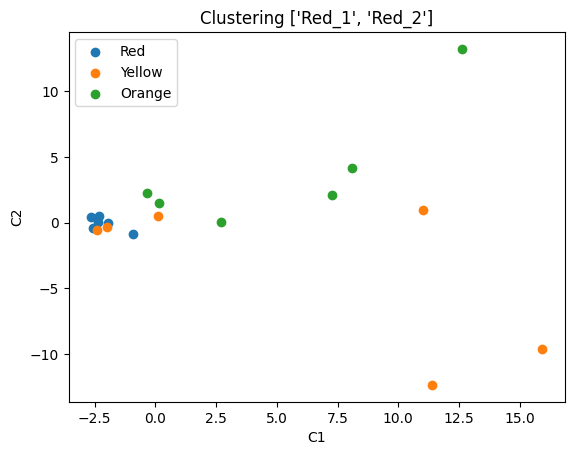

In [41]:
x, y = X_pca[:, 0], X_pca[:, 1]

unique_groups = ["Red", "Yellow", "Orange"] # np.unique(labels)

for group in unique_groups:
    xi = [x[i] for i in range(len(x)) if labels[i] == group]
    yi = [y[i] for i in range(len(y)) if labels[i] == group]
    plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()

In [42]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=3).fit_transform(X_scaled)

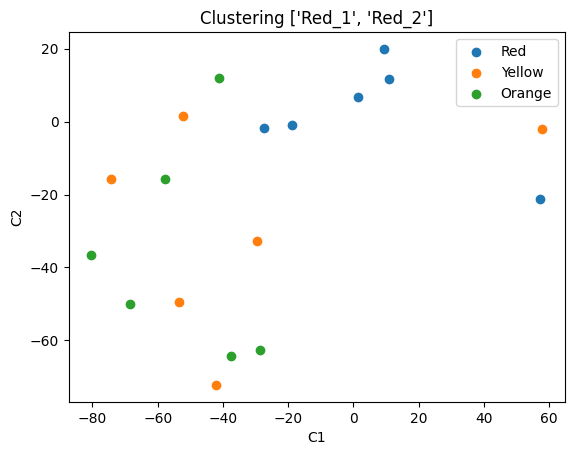

In [43]:
x, y = X_tsne[:, 0], X_tsne[:, 1]

unique_groups = ["Red", "Yellow", "Orange"] # np.unique(labels)

for group in unique_groups:
    xi = [x[i] for i in range(len(x)) if labels[i] == group]
    yi = [y[i] for i in range(len(y)) if labels[i] == group]
    plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()